# to do:
2.Sperate imputation from the read covariate section of the trial loop , so down the line, summary stats for the trials can be obtained from unimputed data


X. systolic BP an some other covariates are saved in an inconsistent way. Make sure all variables are saved in a consitent format so reading and merging can be done easily, i.e. ["patid","eventdate","value"] fixed: through updating the data_dict structure


In [1]:
import os
spark_home=os.environ.get('SPARK_HOME',None)
print(spark_home)
import os
java_home=os.environ.get('JAVA_HOME',None)
print(java_home)

None
/home/mo/anaconda3/envs/emulatedTrial


In [2]:
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64/jre"
import sys
sys.path

['/home/shared/mo/HFclusters/dependencies',
 '/home/mo/anaconda3/envs/cprd/lib/python37.zip',
 '/home/mo/anaconda3/envs/cprd/lib/python3.7',
 '/home/mo/anaconda3/envs/cprd/lib/python3.7/lib-dynload',
 '',
 '/home/mo/anaconda3/envs/cprd/lib/python3.7/site-packages',
 '/home/mo/anaconda3/envs/cprd/lib/python3.7/site-packages/IPython/extensions',
 '/home/mo/.ipython']

In [6]:
import itertools
import pandas as pd
import numpy as np
import sys 
import datetime
sys.path.insert(0, '/home/shared/mo/HFclusters/dependencies/CPRD')


from utils.yaml_act import yaml_load
from utils.arg_parse import arg_paser
from CPRD.config.spark import spark_init, read_parquet, read_txt, read_csv
import pyspark.sql.functions as F
from pyspark.sql.types import StructType,StructField, StringType, DateType
from CPRD.functions import tables, merge, cohort_select,risk_prediction, modalities, MedicalDictionary, risk_prediction, predictor_extractor
from pyspark.sql import Window
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter
import warnings
import copy

from pyspark.sql.types import IntegerType, DoubleType
from pyspark.ml.feature import StringIndexer

warnings.filterwarnings("ignore")

class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [7]:
str('hi')

'hi'

In [8]:
def ohe_pretty(df,column):
    distinct_values = df.select(column)\
                    .distinct()\
                    .rdd\
                    .flatMap(lambda x: x).collect()
    for distinct_value in distinct_values:
        function = F.udf(lambda item: 
                       1 if item == distinct_value else 0, 
                       IntegerType())
        try:
            new_column_name = column+'_'+distinct_value
        except: 
            print('Error: column value is '+str(column)+' and distinct_value is: '+str(distinct_value))
        df = df.withColumn(new_column_name, function(F.col(column)))
    return df

In [9]:
def extract_long_covariate(variables,eligible_cohort_df,trial_dict,duration,trial_enrolment_startdate,trial_enrolment_enddate,aggregate=None):
    eligible_cohort_df=eligible_cohort.select('patid').alias('df').cache()
    for var in variables.keys():
        path=trial_dict['covariates_long'][var]['path']

        if trial_dict['covariates_long'][var]['type']=='binary':
            covariate=read_csv(spark.sqlContext,path).select(['patid',trial_dict['covariates_long'][var]["eventdate"]]).\
            withColumnRenamed(trial_dict['covariates_long'][var]["eventdate"],'eventdate').\
            withColumn('eventdate',F.to_date(F.col("eventdate"),"yyyy-MM-dd").alias('eventdate')).\
            join(eligible_cohort_df,on='patid',how='leftsemi')

            covariate=covariate.where((F.col("eventdate")>trial_enrolment_startdate-duration) & (F.col("eventdate")<trial_enrolment_enddate))

            eligible_cohort_df=eligible_cohort_df.withColumn(var,F.when(eligible_cohort.patid.isin(covariate.select(F.collect_set("patid")).collect()[0][0]),1).otherwise(0)).cache()   
        elif trial_dict['covariates_long'][var]['type']=='cat':
            covariate=read_csv(spark.sqlContext,path).select(['patid',
                                                              trial_dict['covariates_long'][var]["eventdate"],
                                                             trial_dict['covariates_long'][var]["value"]]).\
            withColumn('eventdate',F.to_date(F.col("eventdate"),"yyyy-MM-dd").alias('eventdate')).\
            join(eligible_cohort_df,on='patid',how='leftsemi')

            #aggregation
            if aggregate=='last':
                w=Window.partitionBy('patid').orderBy(F.col('eventdate').desc())
                covariate=covariate.withColumn("last_entry",F.first('eventdate').over(w))
                covariate=covariate.where(covariate.eventdate==covariate.last_entry).dropDuplicates(['patid']).drop("last_entry","eventdate")
                covariate=eligible_cohort_df.select("patid").join(covariate,on='patid',how='left').withColumnRenamed(trial_dict['covariates_long'][var]["value"],var)

            covariate=covariate.fillna('Null')
            covariate=ohe_pretty(covariate,var).drop(var,variables[var])

            eligible_cohort_df=eligible_cohort_df.join(covariate,on='patid',how='left').cache()    


            #covariate=covariate.where((F.col("eventdate")>trial_enrolment_startdate-duration) & (F.col("eventdate")<trial_enrolment_enddate))

            #eligible_cohort_df=eligible_cohort_df.withColumn(var,F.when(eligible_cohort.patid.isin(covariate.select("patid").distinct().toPandas().patid.tolist()),1).otherwise(0)) 
        elif trial_dict['covariates_long'][var]['type']=='continous':
            covariate=read_csv(spark.sqlContext,path).select(['patid',
                                                              trial_dict['covariates_long'][var]["eventdate"],
                                                             trial_dict['covariates_long'][var]["value"]]).\
            withColumn('eventdate',F.to_date(F.col("eventdate"),"yyyy-MM-dd").alias('eventdate')).\
            withColumnRenamed(trial_dict['covariates_long'][var]["value"],var).\
            withColumn(var,F.col(var).cast(DoubleType())).\
            join(eligible_cohort_df,on='patid',how='leftsemi')

            covariate=covariate.where((F.col("eventdate")>trial_enrolment_startdate-duration) & (F.col("eventdate")<trial_enrolment_enddate))

            covariate=covariate.groupBy('patid').agg(F.avg(var).alias(var))

            eligible_cohort_df=eligible_cohort_df.join(covariate,on='patid',how='left').cache()   
    return eligible_cohort_df


In [10]:
def fill_with_mean(df, exclude=set()): 
    stats = df.agg(*(
        F.avg(c).alias(c) for c in df.columns if c not in exclude
    ))
    return df.na.fill(stats.first().asDict())

In [11]:
args = dotdict({'params': '/home/shared/mo/HFclusters/dependencies/CPRD/config/config.yaml'})
params = yaml_load(args.params)
params['pyspark']={'temp':'/home/shared/mo/HFclusters/dependencies/sparkDeletable',
                   'pyspark_env':'/home/mo/anaconda3/envs/cprd/bin/python3.7'}
spark_params = params['pyspark']
spark = spark_init(spark_params)
file = params['file_path']
# data_params = params['params']1

2022-09-21 18:52:42 WARN  Utils:66 - Your hostname, deepmedicine resolves to a loopback address: 127.0.1.1; using 163.1.176.44 instead (on interface enp4s0)
2022-09-21 18:52:42 WARN  Utils:66 - Set SPARK_LOCAL_IP if you need to bind to another address
2022-09-21 18:52:43 WARN  NativeCodeLoader:62 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


2022-09-21 18:52:43 WARN  SparkConf:66 - Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


# 1. Load the main demographic file

In [12]:
data_eval =read_parquet(spark.sqlContext,'/home/shared/yikuan/Mo/analysis/CPC/result.parquet').select(['patid', 'event', 'time', 'label'])
demographic = read_parquet(spark.sqlContext,'/home/shared/yikuan/Mo/demographics.parquet/').withColumnRenamed("eventdate","HFdate")

In [13]:
patient = tables.retrieve_patient(dir=file['patient'], spark=spark)\
.select(['patid','tod','deathdate','pracid'])\
.join(demographic,on='patid',how="leftsemi")\
.join(tables.retrieve_death(dir=file['death'], spark=spark).select('patid','dod'),on='patid',how='left')\
.join(tables.retrieve_practice(dir=file['practice'], spark=spark).select(['pracid','lcd']),on='pracid',how='left')\
.cache()
patient=patient.withColumn('Date of death',F.when(F.col('dod').isNotNull(),F.col('dod')).\
                  otherwise(F.col('deathdate'))).drop("deathdate",'dod')\
.withColumn('end of followup',F.least('tod','lcd','Date of death'))\
.withColumn("died",F.when(F.col("Date of death")==F.col("end of followup"),1).otherwise(0))\
.select(['patid','Date of death','end of followup','died'])\
.cache()

In [14]:
demographic=demographic.join(patient,on='patid',how='left').cache()

2022-09-21 18:52:56 WARN  Utils:66 - Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.debug.maxToStringFields' in SparkEnv.conf.


<AxesSubplot:>

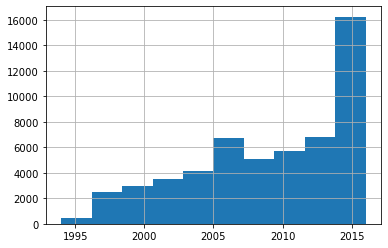

In [15]:
dates_temp=demographic.select("end of followup").toPandas()
dates_temp.apply(lambda x:x[0].year, axis=1).hist()

# 2. Load the related files

In [16]:
trial_dict={'exposure':{"path":"/home/shared/mo/HFclusters/cohort_parquets/Meds/Aldosterone/part-00000-e3c88430-60b3-48f3-8369-17f9ca407a3a-c000.csv",
                       "type":'binary',
                        'eventdate':'eventdate'},
            'covariates_long':{'ACE':{"path":"/home/shared/mo/HFclusters/cohort_parquets/Meds/ACEs/part-00000-307604d4-9a13-4db9-8876-cd52bd186622-c000.csv",
                                      "type":'binary',
                                     'eventdate':'eventdate'},
                               'Amiloride':{'path':"/home/shared/mo/HFclusters/cohort_parquets/Meds/Amiloride/part-00000-a464b516-4603-462b-b11c-64846a8b6f4a-c000.csv",
                                            'type':'binary',
                                           'eventdate':'eventdate'},
                               'Anticoagulant':{'path':"/home/shared/mo/HFclusters/cohort_parquets/Meds/anticoagulant/part-00000-c71c355d-de97-4bf0-83d1-f368050065cb-c000.csv",
                                                'type':'binary',
                                               'eventdate':'eventdate'},
                               'Antiplatelet':{'path':"/home/shared/mo/HFclusters/cohort_parquets/Meds/antiplatelet/part-00000-7ef56a1f-8c35-467b-820c-aa6efccca717-c000.csv",
                                               'type':'binary',
                                              'eventdate':'eventdate'},
                               'ARB':{"path":"/home/shared/mo/HFclusters/cohort_parquets/Meds/ARBs/part-00000-865553e1-ed42-46a6-83b7-f5a0280c864d-c000.csv",
                                      'type':'binary',
                                     'eventdate':'eventdate'},
                               'BB':{'path':"/home/shared/mo/HFclusters/cohort_parquets/Meds/BBs/part-00000-26710e1d-dbb2-481c-8c25-4d8d288082d3-c000.csv",
                                     'type':'binary',
                                    'eventdate':'eventdate'},
                               'Digoxin':{"path":"/home/shared/mo/HFclusters/cohort_parquets/Meds/digoxin/part-00000-181a4f84-cd8a-4287-ba2b-343dc9c306e9-c000.csv",
                                          'type':'binary',
                                         'eventdate':'eventdate'},
                               'Diuretic':{'path':"/home/shared/mo/HFclusters/cohort_parquets/Meds/diuretic/part-00000-afa2effc-4ce2-46fd-97b3-52e7f5615fb0-c000.csv",
                                           'type':'binary',
                                          'eventdate':'eventdate'},
                               'Nitrates':{'path':"/home/shared/mo/HFclusters/cohort_parquets/Meds/nitrates/part-00000-71ac7324-ea87-4a93-810c-4701e0054474-c000.csv",
                                           'type':'binary',
                                          'eventdate':'eventdate'},
                               'Statins':{'path':"/home/shared/mo/HFclusters/cohort_parquets/Meds/statins/part-00000-ce25f283-2221-4353-98cd-d67bc1dacbdd-c000.csv", 
                                          'type':'binary',
                                          'eventdate':'eventdate'},
                               'Alcohol consumption':{'path':"/home/shared/mo/HFclusters/cohort_parquets/alcoholcsv/part-00000-f62d7ace-c45e-485a-be09-ef619fe82df9-c000.csv",
                                                      'type':'cat',
                                                      'eventdate':'eventdate',
                                                      'value':'alcohol'},
                               'Smoking status':{'path':"/home/shared/mo/HFclusters/cohort_parquets/smokingcsv/part-00000-1af6e01c-3aed-47ad-b284-7d935f155e8a-c000.csv",
                                                      'type':'cat',
                                     'eventdate':'eventdate',
                                     'value':'smoke'},
                               'BMI':{'path':"/home/shared/mo/HFclusters/cohort_parquets/bmicsv/part-00000-5b9aecf4-fc48-4a0b-845e-cd0c6b528657-c000.csv",
                                                      'type':'continous',
                                     'eventdate':'eventdate',
                                     'value':'BMI'},
                               'HR':{'path':"/home/shared/mo/HFclusters/cohort_parquets/hrcsv/part-00000-76c35aec-df7f-4800-8d0f-e8e41490507e-c000.csv",
                                    'type':'continous',
                                     'eventdate':'eventdate',
                                     'value':'heart_rate'},
                               'Systolic BP':{'path':"/home/shared/mo/HFclusters/cohort_parquets/sys_bpcsv/part-00000-c8f11575-2068-48a0-aee1-4e53e42c2f7e-c000.csv",
                                              'type':'continous',
                                              'eventdate':'eventdate',
                                              'value':'systolic'},
                               'Haemoglobin':{'path':"/home/shared/mo/HFclusters/cohort_parquets/haemoglobin/part-00000-7efb16e2-e584-489e-a3a4-366b9ae84d5b-c000.csv",
                                             'type':'continous',
                                             'eventdate':'eventdate',
                                             'value':'haemoglobin'},
                               'Potassium':{'path':"/home/shared/mo/HFclusters/cohort_parquets/potassium/part-00000-6784e63e-bf6c-4ef6-b7ea-72818d4cffee-c000.csv",
                                            'type':'continous',
                                            'eventdate':'eventdate',
                                            'value':'potassium'},
                               "HF type":{'path':"/home/shared/mo/HFclusters/cohort_parquets/hftype/part-00000-7080bb49-8426-4afb-8f9d-e7326e8a9082-c000.csv",
                                          'type':'cat',
                                          'eventdate':'eventdate',
                                          'value':'HF type'},
                               "NYHA class":{'path':"/home/shared/mo/HFclusters/cohort_parquets/nyha/part-00000-fefa6148-f1ca-44cc-ba26-192827992938-c000.csv",
                                             'type':'cat',
                                             'eventdate':'eventdate',
                                             'value':'medcode'},#['18853','13189','19066','51214']#class I, II, III & IV
                               "Cancer":{'path':"/home/shared/mo/HFclusters/cohort_parquets/malignant_cancer/part-00000-3a17e731-6aab-46d1-932a-e9d7f0174ef2-c000.csv",
                                                      'type':'binary',
                                                      'eventdate':'malignant cancer'},
                               "Mental or behavioral disorder":{'path':"/home/shared/mo/HFclusters/cohort_parquets/mental_or_behavioral_disorder/part-00000-3761b121-e663-45d3-9c0c-67660a7f95e0-c000.csv",
                                                      'type':'binary',
                                                      'eventdate':'mental or behavioral disorder'},
                               "Musculoskeletal or connective tissue diagnosis":{'path':"/home/shared/mo/HFclusters/cohort_parquets/musculoskeletal_or_connective_tissue_diagnosis/part-00000-51f58892-6a64-4c0a-9e8a-5cdc60481930-c000.csv",
                                                      'type':'binary',
                                                      'eventdate':'Musculoskeletal or connective tissue'}
                              },
            'first diagnoses':{'path':"/home/shared/mo/HFclusters/cohort_parquets/first_diagnoses/part-00000-39a65ed5-6497-4f42-a61e-c86ab5b1d2a4-c000.csv"}
           }

In [17]:
for covariate in trial_dict['covariates_long'].keys():
    if covariate=='Cancer':
        print(covariate)
        if trial_dict['covariates_long'][covariate]["type"]=='binary':
            covariate_df=read_csv(spark.sqlContext,trial_dict['covariates_long'][covariate]["path"])\
            .select(['patid',trial_dict['covariates_long'][covariate]["eventdate"]])
        else:
            covariate_df=read_csv(spark.sqlContext,trial_dict['covariates_long'][covariate]["path"])\
            .select(['patid',trial_dict['covariates_long'][covariate]["eventdate"],trial_dict['covariates_long'][covariate]["value"]])
        covariate_df.show(5)
#exposure = read_csv(spark.sqlContext,trial_dict['exposure']['path'])

Cancer
+--------+----------------+
|   patid|malignant cancer|
+--------+----------------+
|10555460|      2007-08-30|
|10555460|      2007-09-19|
|10555460|      2008-02-14|
|10555460|      2008-04-25|
|10555460|      2008-04-25|
+--------+----------------+
only showing top 5 rows



# Trial

In [18]:
demographic.show()

+--------+------+----------+------+----------+----------+----------+----------+----------+----+----------+-------------+---------------+----+
|   patid|gender|       dob|region|     start| startdate|       end|   enddate|    HFdate|code|  baseline|Date of death|end of followup|died|
+--------+------+----------+------+----------+----------+----------+----------+----------+----+----------+-------------+---------------+----+
|10103660|     2|1923-07-01|     2|1999-03-11|1997-03-11|2012-10-16|2012-10-16|2010-09-10|2906|2008-09-10|   2012-10-16|     2012-10-16|   1|
| 1011171|     1|1919-07-01|     2|2001-01-21|1999-01-21|2007-05-11|2007-05-11|2007-01-23| 398|2005-01-23|   2007-05-11|     2007-05-11|   1|
|10217120|     2|1924-07-01|     6|1991-11-02|1989-11-02|2010-12-02|2010-12-02|2003-05-06| 398|2001-05-06|         null|     2010-12-02|   0|
|10280169|     1|1920-07-01|     5|1993-02-26|1991-02-26|2005-01-19|2005-01-19|2005-01-04| 884|2003-01-04|   2005-01-19|     2005-01-19|   1|
|10417

In [19]:
demographic.select('gender').groupBy('gender').count().show()

+------+-----+
|gender|count|
+------+-----+
|     1|28339|
|     2|25726|
+------+-----+



In [21]:
#def emulate_trials(trial_start_date,trial_enrolment_period,exposure_history,washout_period,followup_period,num_trials=2):
trial_start_date=pd.to_datetime("1-Jan-2000")
trial_enrolment_period=pd.DateOffset(months=1)
exposure_history=read_csv(spark.sqlContext,trial_dict['exposure']["path"]).select(['patid',trial_dict['exposure']["eventdate"]]).\
withColumn('eventdate',F.to_date(F.col("eventdate"),"yyyy-MM-dd").alias('eventdate'))
washout_period=pd.DateOffset(years=2) #this is the time before the trial during which being exposed will lead to the exclusion of the participant from the trial
followup_period=pd.DateOffset(years=5)
num_trials=60

for trial_num in range(num_trials):

    subtrial_enrolment_startdate=trial_start_date+trial_num*trial_enrolment_period
    subtrial_enrolment_enddate=subtrial_enrolment_startdate+(1+trial_num)*trial_enrolment_period

    subtrial_enddate=str(subtrial_enrolment_startdate+followup_period)[:10]

    eligible_cohort=demographic.where((F.col("HFDate")<subtrial_enrolment_startdate) & (F.col("end of followup")>F.lit(subtrial_enrolment_enddate))).\
    select(['patid','gender','dob','HFdate','end of followup','Date of death']).\
    join(data_eval.select(['patid','label']),on='patid',how='inner')\
    .withColumn('end of followup subtrial',
                F.when(F.col('end of followup')<F.lit(subtrial_enddate),F.col('end of followup'))\
                .otherwise(F.lit(subtrial_enddate)))\
    .drop('end of followup')\
    .withColumn('died',
                F.when(F.col('Date of death')<=F.col('end of followup subtrial'),1)\
                .otherwise(0))\
    .withColumn("Time since HF diagnosis [yrs]",F.months_between(F.lit(subtrial_enrolment_startdate),F.col("HFdate"))/12)\
    .withColumn("Time since HF diagnosis [yrs]",F.round("Time since HF diagnosis [yrs]").cast(IntegerType()))


    print("{} participants deemed eligible for trial num {}".format(eligible_cohort.count(),trial_num))


    #1. exclude those with exposure within "washout_period" before the trial startdate
    exposure_history_trial_participants=exposure_history.join(eligible_cohort,on="patid",how="leftsemi")
    patients_excluded_due_to_prior_exposure=exposure_history_trial_participants.\
    where((F.col("eventdate")>subtrial_enrolment_startdate-washout_period) & (F.col("eventdate")<subtrial_enrolment_startdate)).\
    select("patid").distinct().toPandas()["patid"].tolist()

    eligible_cohort=eligible_cohort.filter(~eligible_cohort.patid.isin(patients_excluded_due_to_prior_exposure))
    print("{} participants excluded due the exposure or washout period overlapping with the trial enrolment".format(len(patients_excluded_due_to_prior_exposure)))

    #2. Identify whether the patient has received the exposure during the trial enrolment period, 
    exposure_arm=exposure_history_trial_participants.\
    where((F.col("eventdate")>subtrial_enrolment_startdate) & (F.col("eventdate")<subtrial_enrolment_enddate)).\
    select("patid").distinct().toPandas()["patid"].tolist()

    eligible_cohort=eligible_cohort\
    .withColumn('Treatment',F.when(eligible_cohort.patid.isin(exposure_arm),1).otherwise(0))

    eligible_cohort=eligible_cohort\
    .withColumn('Age',F.round(F.months_between(F.to_date(F.lit(str(subtrial_enrolment_startdate)[:10])),F.col("dob"))/F.lit(12),0)).cache()

    print("Trial {}: {} participants, {} exposure".format(trial_num, eligible_cohort.count(),eligible_cohort.where(F.col("Treatment")==1).count()))

    #3. extract the covariates 
    med_vars={'ACE':'', 'Amiloride':'', 'Anticoagulant':'', 'Antiplatelet':'', 'ARB':'', 'BB':'', 'Digoxin':'', 'Diuretic':'', 'Nitrates':'', 'Statins':''}
    cat_vars={'Smoking status':"Smoking status_3",'Alcohol consumption':'Alcohol consumption_3','HF type':"HF type_HF-UNS","NYHA class":"NYHA class_18853"}
    measure_vars={'BMI':'','HR':'','Systolic BP':'','Haemoglobin':'','Potassium':''}
    disease_vars={"Cancer":'',"Mental or behavioral disorder":'',"Musculoskeletal or connective tissue diagnosis":''}
    tidy_df=extract_long_covariate(med_vars,eligible_cohort,trial_dict,pd.DateOffset(months=6),subtrial_enrolment_startdate,subtrial_enrolment_enddate,aggregate=None).\
    join(extract_long_covariate(cat_vars,eligible_cohort,trial_dict,pd.DateOffset(years=3),subtrial_enrolment_startdate,subtrial_enrolment_enddate,aggregate='last'),on='patid',how='outer').\
    join(extract_long_covariate(measure_vars,eligible_cohort,trial_dict,pd.DateOffset(years=1),subtrial_enrolment_startdate,subtrial_enrolment_enddate,aggregate=None),on='patid',how='outer').\
    join(extract_long_covariate(disease_vars,eligible_cohort,trial_dict,pd.DateOffset(years=3),subtrial_enrolment_startdate,subtrial_enrolment_enddate,aggregate=None),on='patid',how='outer')

    covariate=read_csv(spark.sqlContext,trial_dict['first diagnoses']["path"]).drop("Musculoskeletal or connective tissue",
                                                                                     "mental or behavioral disorder",
                                                                                    "malignant cancer").join(eligible_cohort.select('patid'),on='patid',how='right').fillna(0)
    covariate=covariate.select(['patid']+[F.when(F.col(c)<=F.lit(subtrial_enrolment_startdate),1).otherwise(0).alias(c) for c in covariate.columns if c!='patid']).cache()

    tidy_df=tidy_df.join(covariate,on='patid',how='outer')\
    .join(eligible_cohort.select(['patid','gender','Age',"Time since HF diagnosis [yrs]",'Treatment','end of followup subtrial','died']),on='patid',how='left')

    tidy_df=tidy_df.join(ohe_pretty(tidy_df.select(['patid','gender']),'gender').select(['patid','gender_1']).withColumnRenamed('gender_1','Gender_Male'),on='patid',how='left').drop('gender').cache()

    #Save data
    mapping = {col:col.replace(' ','_') for col in tidy_df.columns}
    tidy_df=tidy_df.select([F.col(c).alias(mapping.get(c, c)) for c in tidy_df.columns]).withColumn("Trial_date",F.lit(str(subtrial_enrolment_startdate)[:10]))

    tidy_df.write.format("parquet").save("/home/shared/mo/HFclusters/dependencies/emulated_trials_parquets/"+"trial"+str(trial_num))


5923 participants deemed eligible for trial num 0
122 participants excluded due the exposure or washout period overlapping with the trial enrolment


2022-09-21 18:56:56 WARN  CacheManager:66 - Asked to cache already cached data.
Trial 0: 5801 participants, 17 exposure


2022-09-21 18:57:38 WARN  CacheManager:66 - Asked to cache already cached data.


2022-09-21 18:57:58 WARN  CacheManager:66 - Asked to cache already cached data.
2022-09-21 18:57:59 WARN  CacheManager:66 - Asked to cache already cached data.


5956 participants deemed eligible for trial num 1
138 participants excluded due the exposure or washout period overlapping with the trial enrolment


Trial 1: 5818 participants, 23 exposure


2022-09-21 18:59:29 WARN  CacheManager:66 - Asked to cache already cached data.


2022-09-21 18:59:47 WARN  CacheManager:66 - Asked to cache already cached data.
2022-09-21 18:59:48 WARN  CacheManager:66 - Asked to cache already cached data.


5930 participants deemed eligible for trial num 2


142 participants excluded due the exposure or washout period overlapping with the trial enrolment


Trial 2: 5788 participants, 43 exposure


2022-09-21 19:01:18 WARN  CacheManager:66 - Asked to cache already cached data.


2022-09-21 19:01:34 WARN  CacheManager:66 - Asked to cache already cached data.
2022-09-21 19:01:35 WARN  CacheManager:66 - Asked to cache already cached data.


5946 participants deemed eligible for trial num 3
153 participants excluded due the exposure or washout period overlapping with the trial enrolment


Trial 3: 5793 participants, 48 exposure


2022-09-21 19:02:59 WARN  CacheManager:66 - Asked to cache already cached data.


2022-09-21 19:03:13 WARN  CacheManager:66 - Asked to cache already cached data.
2022-09-21 19:03:14 WARN  CacheManager:66 - Asked to cache already cached data.


5966 participants deemed eligible for trial num 4
165 participants excluded due the exposure or washout period overlapping with the trial enrolment


Trial 4: 5801 participants, 55 exposure


2022-09-21 19:04:31 WARN  CacheManager:66 - Asked to cache already cached data.


2022-09-21 19:04:48 WARN  CacheManager:66 - Asked to cache already cached data.
2022-09-21 19:04:49 WARN  CacheManager:66 - Asked to cache already cached data.


5933 participants deemed eligible for trial num 5
176 participants excluded due the exposure or washout period overlapping with the trial enrolment


Trial 5: 5757 participants, 77 exposure


2022-09-21 19:06:06 WARN  CacheManager:66 - Asked to cache already cached data.


2022-09-21 19:06:22 WARN  CacheManager:66 - Asked to cache already cached data.
2022-09-21 19:06:23 WARN  CacheManager:66 - Asked to cache already cached data.


5906 participants deemed eligible for trial num 6
188 participants excluded due the exposure or washout period overlapping with the trial enrolment


Trial 6: 5718 participants, 75 exposure


2022-09-21 19:07:40 WARN  CacheManager:66 - Asked to cache already cached data.


2022-09-21 19:07:55 WARN  CacheManager:66 - Asked to cache already cached data.
2022-09-21 19:07:56 WARN  CacheManager:66 - Asked to cache already cached data.


5846 participants deemed eligible for trial num 7
194 participants excluded due the exposure or washout period overlapping with the trial enrolment


Trial 7: 5652 participants, 95 exposure


2022-09-21 19:09:14 WARN  CacheManager:66 - Asked to cache already cached data.


2022-09-21 19:09:29 WARN  CacheManager:66 - Asked to cache already cached data.
2022-09-21 19:09:31 WARN  CacheManager:66 - Asked to cache already cached data.


5836 participants deemed eligible for trial num 8


204 participants excluded due the exposure or washout period overlapping with the trial enrolment


Trial 8: 5632 participants, 100 exposure


2022-09-21 19:10:54 WARN  CacheManager:66 - Asked to cache already cached data.


2022-09-21 19:11:08 WARN  CacheManager:66 - Asked to cache already cached data.
2022-09-21 19:11:09 WARN  CacheManager:66 - Asked to cache already cached data.


5773 participants deemed eligible for trial num 9
213 participants excluded due the exposure or washout period overlapping with the trial enrolment


Trial 9: 5560 participants, 108 exposure


2022-09-21 19:12:26 WARN  CacheManager:66 - Asked to cache already cached data.


2022-09-21 19:12:42 WARN  CacheManager:66 - Asked to cache already cached data.
2022-09-21 19:12:44 WARN  CacheManager:66 - Asked to cache already cached data.


5740 participants deemed eligible for trial num 10
213 participants excluded due the exposure or washout period overlapping with the trial enrolment


Trial 10: 5527 participants, 109 exposure


2022-09-21 19:14:02 WARN  CacheManager:66 - Asked to cache already cached data.


2022-09-21 19:14:19 WARN  CacheManager:66 - Asked to cache already cached data.
2022-09-21 19:14:21 WARN  CacheManager:66 - Asked to cache already cached data.


5689 participants deemed eligible for trial num 11
216 participants excluded due the exposure or washout period overlapping with the trial enrolment


Trial 11: 5473 participants, 127 exposure


2022-09-21 19:15:37 WARN  CacheManager:66 - Asked to cache already cached data.


2022-09-21 19:15:52 WARN  CacheManager:66 - Asked to cache already cached data.
2022-09-21 19:15:54 WARN  CacheManager:66 - Asked to cache already cached data.


5625 participants deemed eligible for trial num 12
220 participants excluded due the exposure or washout period overlapping with the trial enrolment
Trial 12: 5405 participants, 126 exposure


2022-09-21 19:17:19 WARN  CacheManager:66 - Asked to cache already cached data.


2022-09-21 19:17:35 WARN  CacheManager:66 - Asked to cache already cached data.
2022-09-21 19:17:36 WARN  CacheManager:66 - Asked to cache already cached data.


5603 participants deemed eligible for trial num 13


223 participants excluded due the exposure or washout period overlapping with the trial enrolment


Trial 13: 5380 participants, 131 exposure


2022-09-21 19:18:57 WARN  CacheManager:66 - Asked to cache already cached data.


2022-09-21 19:19:13 WARN  CacheManager:66 - Asked to cache already cached data.
2022-09-21 19:19:15 WARN  CacheManager:66 - Asked to cache already cached data.


5595 participants deemed eligible for trial num 14
224 participants excluded due the exposure or washout period overlapping with the trial enrolment
Trial 14: 5371 participants, 134 exposure


2022-09-21 19:20:35 WARN  CacheManager:66 - Asked to cache already cached data.


2022-09-21 19:20:54 WARN  CacheManager:66 - Asked to cache already cached data.
2022-09-21 19:20:55 WARN  CacheManager:66 - Asked to cache already cached data.


5584 participants deemed eligible for trial num 15


234 participants excluded due the exposure or washout period overlapping with the trial enrolment


Trial 15: 5350 participants, 151 exposure


2022-09-21 19:22:17 WARN  CacheManager:66 - Asked to cache already cached data.


2022-09-21 19:22:34 WARN  CacheManager:66 - Asked to cache already cached data.
2022-09-21 19:22:36 WARN  CacheManager:66 - Asked to cache already cached data.


5580 participants deemed eligible for trial num 16
242 participants excluded due the exposure or washout period overlapping with the trial enrolment
Trial 16: 5338 participants, 157 exposure


2022-09-21 19:24:03 WARN  CacheManager:66 - Asked to cache already cached data.


2022-09-21 19:24:22 WARN  CacheManager:66 - Asked to cache already cached data.
2022-09-21 19:24:23 WARN  CacheManager:66 - Asked to cache already cached data.


5532 participants deemed eligible for trial num 17
242 participants excluded due the exposure or washout period overlapping with the trial enrolment
Trial 17: 5290 participants, 155 exposure


2022-09-21 19:25:46 WARN  CacheManager:66 - Asked to cache already cached data.


2022-09-21 19:26:04 WARN  CacheManager:66 - Asked to cache already cached data.
2022-09-21 19:26:05 WARN  CacheManager:66 - Asked to cache already cached data.


5457 participants deemed eligible for trial num 18
253 participants excluded due the exposure or washout period overlapping with the trial enrolment


Trial 18: 5204 participants, 152 exposure


2022-09-21 19:27:28 WARN  CacheManager:66 - Asked to cache already cached data.


2022-09-21 19:27:46 WARN  CacheManager:66 - Asked to cache already cached data.
2022-09-21 19:27:47 WARN  CacheManager:66 - Asked to cache already cached data.


5413 participants deemed eligible for trial num 19
271 participants excluded due the exposure or washout period overlapping with the trial enrolment
Trial 19: 5142 participants, 155 exposure


2022-09-21 19:29:00 WARN  CacheManager:66 - Asked to cache already cached data.


2022-09-21 19:29:18 WARN  CacheManager:66 - Asked to cache already cached data.
2022-09-21 19:29:19 WARN  CacheManager:66 - Asked to cache already cached data.


5360 participants deemed eligible for trial num 20


272 participants excluded due the exposure or washout period overlapping with the trial enrolment


Trial 20: 5088 participants, 167 exposure


2022-09-21 19:30:42 WARN  CacheManager:66 - Asked to cache already cached data.


2022-09-21 19:30:56 WARN  CacheManager:66 - Asked to cache already cached data.
2022-09-21 19:30:57 WARN  CacheManager:66 - Asked to cache already cached data.


5285 participants deemed eligible for trial num 21
259 participants excluded due the exposure or washout period overlapping with the trial enrolment
Trial 21: 5026 participants, 180 exposure


2022-09-21 19:32:18 WARN  CacheManager:66 - Asked to cache already cached data.


2022-09-21 19:32:34 WARN  CacheManager:66 - Asked to cache already cached data.
2022-09-21 19:32:35 WARN  CacheManager:66 - Asked to cache already cached data.


5303 participants deemed eligible for trial num 22
271 participants excluded due the exposure or washout period overlapping with the trial enrolment


Trial 22: 5032 participants, 178 exposure


2022-09-21 19:33:53 WARN  CacheManager:66 - Asked to cache already cached data.


2022-09-21 19:34:08 WARN  CacheManager:66 - Asked to cache already cached data.
2022-09-21 19:34:10 WARN  CacheManager:66 - Asked to cache already cached data.


5275 participants deemed eligible for trial num 23
277 participants excluded due the exposure or washout period overlapping with the trial enrolment


Trial 23: 4998 participants, 179 exposure


2022-09-21 19:35:33 WARN  CacheManager:66 - Asked to cache already cached data.


2022-09-21 19:35:48 WARN  CacheManager:66 - Asked to cache already cached data.
2022-09-21 19:35:50 WARN  CacheManager:66 - Asked to cache already cached data.


5164 participants deemed eligible for trial num 24
280 participants excluded due the exposure or washout period overlapping with the trial enrolment
Trial 24: 4884 participants, 177 exposure


2022-09-21 19:37:04 WARN  CacheManager:66 - Asked to cache already cached data.


2022-09-21 19:37:20 WARN  CacheManager:66 - Asked to cache already cached data.
2022-09-21 19:37:21 WARN  CacheManager:66 - Asked to cache already cached data.


5171 participants deemed eligible for trial num 25
279 participants excluded due the exposure or washout period overlapping with the trial enrolment


Trial 25: 4892 participants, 187 exposure


2022-09-21 19:38:39 WARN  CacheManager:66 - Asked to cache already cached data.


2022-09-21 19:38:54 WARN  CacheManager:66 - Asked to cache already cached data.
2022-09-21 19:38:56 WARN  CacheManager:66 - Asked to cache already cached data.


5108 participants deemed eligible for trial num 26
283 participants excluded due the exposure or washout period overlapping with the trial enrolment


Trial 26: 4825 participants, 187 exposure


2022-09-21 19:40:13 WARN  CacheManager:66 - Asked to cache already cached data.


2022-09-21 19:40:30 WARN  CacheManager:66 - Asked to cache already cached data.
2022-09-21 19:40:31 WARN  CacheManager:66 - Asked to cache already cached data.


5080 participants deemed eligible for trial num 27


281 participants excluded due the exposure or washout period overlapping with the trial enrolment


Trial 27: 4799 participants, 193 exposure


2022-09-21 19:41:50 WARN  CacheManager:66 - Asked to cache already cached data.


2022-09-21 19:42:08 WARN  CacheManager:66 - Asked to cache already cached data.
2022-09-21 19:42:09 WARN  CacheManager:66 - Asked to cache already cached data.


5073 participants deemed eligible for trial num 28


282 participants excluded due the exposure or washout period overlapping with the trial enrolment


Trial 28: 4791 participants, 202 exposure


2022-09-21 19:43:31 WARN  CacheManager:66 - Asked to cache already cached data.


2022-09-21 19:43:48 WARN  CacheManager:66 - Asked to cache already cached data.
2022-09-21 19:43:49 WARN  CacheManager:66 - Asked to cache already cached data.


5061 participants deemed eligible for trial num 29


286 participants excluded due the exposure or washout period overlapping with the trial enrolment


Trial 29: 4775 participants, 206 exposure


2022-09-21 19:45:08 WARN  CacheManager:66 - Asked to cache already cached data.


2022-09-21 19:45:26 WARN  CacheManager:66 - Asked to cache already cached data.
2022-09-21 19:45:28 WARN  CacheManager:66 - Asked to cache already cached data.


5001 participants deemed eligible for trial num 30
282 participants excluded due the exposure or washout period overlapping with the trial enrolment
Trial 30: 4719 participants, 206 exposure


2022-09-21 19:46:50 WARN  CacheManager:66 - Asked to cache already cached data.


2022-09-21 19:47:07 WARN  CacheManager:66 - Asked to cache already cached data.
2022-09-21 19:47:09 WARN  CacheManager:66 - Asked to cache already cached data.


4942 participants deemed eligible for trial num 31
286 participants excluded due the exposure or washout period overlapping with the trial enrolment
Trial 31: 4656 participants, 185 exposure


2022-09-21 19:48:32 WARN  CacheManager:66 - Asked to cache already cached data.


2022-09-21 19:48:51 WARN  CacheManager:66 - Asked to cache already cached data.
2022-09-21 19:48:52 WARN  CacheManager:66 - Asked to cache already cached data.


4907 participants deemed eligible for trial num 32


288 participants excluded due the exposure or washout period overlapping with the trial enrolment


Trial 32: 4619 participants, 195 exposure


2022-09-21 19:50:19 WARN  CacheManager:66 - Asked to cache already cached data.


2022-09-21 19:50:33 WARN  CacheManager:66 - Asked to cache already cached data.
2022-09-21 19:50:34 WARN  CacheManager:66 - Asked to cache already cached data.


4865 participants deemed eligible for trial num 33


284 participants excluded due the exposure or washout period overlapping with the trial enrolment


Trial 33: 4581 participants, 205 exposure


2022-09-21 19:52:02 WARN  CacheManager:66 - Asked to cache already cached data.


2022-09-21 19:52:16 WARN  CacheManager:66 - Asked to cache already cached data.
2022-09-21 19:52:17 WARN  CacheManager:66 - Asked to cache already cached data.


4872 participants deemed eligible for trial num 34
279 participants excluded due the exposure or washout period overlapping with the trial enrolment


Trial 34: 4593 participants, 208 exposure


2022-09-21 19:53:34 WARN  CacheManager:66 - Asked to cache already cached data.


2022-09-21 19:53:52 WARN  CacheManager:66 - Asked to cache already cached data.
2022-09-21 19:53:54 WARN  CacheManager:66 - Asked to cache already cached data.


4835 participants deemed eligible for trial num 35
278 participants excluded due the exposure or washout period overlapping with the trial enrolment


Trial 35: 4557 participants, 220 exposure


2022-09-21 19:55:16 WARN  CacheManager:66 - Asked to cache already cached data.


2022-09-21 19:55:32 WARN  CacheManager:66 - Asked to cache already cached data.
2022-09-21 19:55:34 WARN  CacheManager:66 - Asked to cache already cached data.


4769 participants deemed eligible for trial num 36
274 participants excluded due the exposure or washout period overlapping with the trial enrolment


Trial 36: 4495 participants, 228 exposure


2022-09-21 19:56:56 WARN  CacheManager:66 - Asked to cache already cached data.


2022-09-21 19:57:10 WARN  CacheManager:66 - Asked to cache already cached data.
2022-09-21 19:57:12 WARN  CacheManager:66 - Asked to cache already cached data.


4770 participants deemed eligible for trial num 37
272 participants excluded due the exposure or washout period overlapping with the trial enrolment
Trial 37: 4498 participants, 233 exposure


2022-09-21 19:58:28 WARN  CacheManager:66 - Asked to cache already cached data.


2022-09-21 19:58:44 WARN  CacheManager:66 - Asked to cache already cached data.
2022-09-21 19:58:45 WARN  CacheManager:66 - Asked to cache already cached data.


4766 participants deemed eligible for trial num 38
266 participants excluded due the exposure or washout period overlapping with the trial enrolment
Trial 38: 4500 participants, 243 exposure


2022-09-21 19:59:59 WARN  CacheManager:66 - Asked to cache already cached data.


2022-09-21 20:00:16 WARN  CacheManager:66 - Asked to cache already cached data.
2022-09-21 20:00:17 WARN  CacheManager:66 - Asked to cache already cached data.


4766 participants deemed eligible for trial num 39
268 participants excluded due the exposure or washout period overlapping with the trial enrolment
Trial 39: 4498 participants, 251 exposure


2022-09-21 20:01:41 WARN  CacheManager:66 - Asked to cache already cached data.


2022-09-21 20:01:55 WARN  CacheManager:66 - Asked to cache already cached data.
2022-09-21 20:01:56 WARN  CacheManager:66 - Asked to cache already cached data.


4750 participants deemed eligible for trial num 40
274 participants excluded due the exposure or washout period overlapping with the trial enrolment


Trial 40: 4476 participants, 243 exposure


2022-09-21 20:03:18 WARN  CacheManager:66 - Asked to cache already cached data.


2022-09-21 20:03:34 WARN  CacheManager:66 - Asked to cache already cached data.
2022-09-21 20:03:36 WARN  CacheManager:66 - Asked to cache already cached data.


4724 participants deemed eligible for trial num 41
275 participants excluded due the exposure or washout period overlapping with the trial enrolment


Trial 41: 4449 participants, 237 exposure


2022-09-21 20:04:59 WARN  CacheManager:66 - Asked to cache already cached data.


2022-09-21 20:05:12 WARN  CacheManager:66 - Asked to cache already cached data.
2022-09-21 20:05:14 WARN  CacheManager:66 - Asked to cache already cached data.


4680 participants deemed eligible for trial num 42
271 participants excluded due the exposure or washout period overlapping with the trial enrolment
Trial 42: 4409 participants, 233 exposure


2022-09-21 20:06:28 WARN  CacheManager:66 - Asked to cache already cached data.


2022-09-21 20:06:43 WARN  CacheManager:66 - Asked to cache already cached data.
2022-09-21 20:06:44 WARN  CacheManager:66 - Asked to cache already cached data.


4647 participants deemed eligible for trial num 43
263 participants excluded due the exposure or washout period overlapping with the trial enrolment
Trial 43: 4384 participants, 231 exposure


2022-09-21 20:08:05 WARN  CacheManager:66 - Asked to cache already cached data.


2022-09-21 20:08:21 WARN  CacheManager:66 - Asked to cache already cached data.
2022-09-21 20:08:23 WARN  CacheManager:66 - Asked to cache already cached data.


4610 participants deemed eligible for trial num 44


259 participants excluded due the exposure or washout period overlapping with the trial enrolment


Trial 44: 4351 participants, 235 exposure


2022-09-21 20:09:34 WARN  CacheManager:66 - Asked to cache already cached data.


2022-09-21 20:09:51 WARN  CacheManager:66 - Asked to cache already cached data.
2022-09-21 20:09:53 WARN  CacheManager:66 - Asked to cache already cached data.


4600 participants deemed eligible for trial num 45
260 participants excluded due the exposure or washout period overlapping with the trial enrolment


Trial 45: 4340 participants, 236 exposure


2022-09-21 20:11:12 WARN  CacheManager:66 - Asked to cache already cached data.


2022-09-21 20:11:30 WARN  CacheManager:66 - Asked to cache already cached data.
2022-09-21 20:11:32 WARN  CacheManager:66 - Asked to cache already cached data.


4564 participants deemed eligible for trial num 46
259 participants excluded due the exposure or washout period overlapping with the trial enrolment
Trial 46: 4305 participants, 236 exposure


2022-09-21 20:12:53 WARN  CacheManager:66 - Asked to cache already cached data.


2022-09-21 20:13:10 WARN  CacheManager:66 - Asked to cache already cached data.
2022-09-21 20:13:12 WARN  CacheManager:66 - Asked to cache already cached data.


4527 participants deemed eligible for trial num 47
259 participants excluded due the exposure or washout period overlapping with the trial enrolment


Trial 47: 4268 participants, 237 exposure


2022-09-21 20:14:33 WARN  CacheManager:66 - Asked to cache already cached data.


2022-09-21 20:14:49 WARN  CacheManager:66 - Asked to cache already cached data.
2022-09-21 20:14:50 WARN  CacheManager:66 - Asked to cache already cached data.


4398 participants deemed eligible for trial num 48


267 participants excluded due the exposure or washout period overlapping with the trial enrolment
Trial 48: 4131 participants, 217 exposure


2022-09-21 20:16:12 WARN  CacheManager:66 - Asked to cache already cached data.


2022-09-21 20:16:32 WARN  CacheManager:66 - Asked to cache already cached data.
2022-09-21 20:16:34 WARN  CacheManager:66 - Asked to cache already cached data.


4378 participants deemed eligible for trial num 49
267 participants excluded due the exposure or washout period overlapping with the trial enrolment


Trial 49: 4111 participants, 209 exposure


2022-09-21 20:17:50 WARN  CacheManager:66 - Asked to cache already cached data.


2022-09-21 20:18:06 WARN  CacheManager:66 - Asked to cache already cached data.
2022-09-21 20:18:07 WARN  CacheManager:66 - Asked to cache already cached data.


4366 participants deemed eligible for trial num 50


274 participants excluded due the exposure or washout period overlapping with the trial enrolment


Trial 50: 4092 participants, 220 exposure


2022-09-21 20:19:26 WARN  CacheManager:66 - Asked to cache already cached data.


2022-09-21 20:19:40 WARN  CacheManager:66 - Asked to cache already cached data.
2022-09-21 20:19:41 WARN  CacheManager:66 - Asked to cache already cached data.


4376 participants deemed eligible for trial num 51


269 participants excluded due the exposure or washout period overlapping with the trial enrolment


Trial 51: 4107 participants, 224 exposure


2022-09-21 20:21:09 WARN  CacheManager:66 - Asked to cache already cached data.


2022-09-21 20:21:25 WARN  CacheManager:66 - Asked to cache already cached data.
2022-09-21 20:21:26 WARN  CacheManager:66 - Asked to cache already cached data.


4366 participants deemed eligible for trial num 52


268 participants excluded due the exposure or washout period overlapping with the trial enrolment


Trial 52: 4098 participants, 224 exposure


2022-09-21 20:22:49 WARN  CacheManager:66 - Asked to cache already cached data.


2022-09-21 20:23:08 WARN  CacheManager:66 - Asked to cache already cached data.
2022-09-21 20:23:09 WARN  CacheManager:66 - Asked to cache already cached data.


4254 participants deemed eligible for trial num 53
261 participants excluded due the exposure or washout period overlapping with the trial enrolment


Trial 53: 3993 participants, 215 exposure


2022-09-21 20:24:29 WARN  CacheManager:66 - Asked to cache already cached data.


2022-09-21 20:24:43 WARN  CacheManager:66 - Asked to cache already cached data.
2022-09-21 20:24:45 WARN  CacheManager:66 - Asked to cache already cached data.


4212 participants deemed eligible for trial num 54
261 participants excluded due the exposure or washout period overlapping with the trial enrolment
Trial 54: 3951 participants, 207 exposure


2022-09-21 20:26:00 WARN  CacheManager:66 - Asked to cache already cached data.


2022-09-21 20:26:15 WARN  CacheManager:66 - Asked to cache already cached data.
2022-09-21 20:26:16 WARN  CacheManager:66 - Asked to cache already cached data.


4183 participants deemed eligible for trial num 55
261 participants excluded due the exposure or washout period overlapping with the trial enrolment
Trial 55: 3922 participants, 214 exposure


2022-09-21 20:27:34 WARN  CacheManager:66 - Asked to cache already cached data.


2022-09-21 20:27:54 WARN  CacheManager:66 - Asked to cache already cached data.
2022-09-21 20:27:56 WARN  CacheManager:66 - Asked to cache already cached data.


4173 participants deemed eligible for trial num 56
270 participants excluded due the exposure or washout period overlapping with the trial enrolment


Trial 56: 3903 participants, 214 exposure


2022-09-21 20:29:05 WARN  CacheManager:66 - Asked to cache already cached data.


2022-09-21 20:29:22 WARN  CacheManager:66 - Asked to cache already cached data.
2022-09-21 20:29:23 WARN  CacheManager:66 - Asked to cache already cached data.


4160 participants deemed eligible for trial num 57


275 participants excluded due the exposure or washout period overlapping with the trial enrolment
Trial 57: 3885 participants, 207 exposure


[Stage 19215:=============================================>    (181 + 19) / 200]

2022-09-21 20:30:40 WARN  CacheManager:66 - Asked to cache already cached data.


2022-09-21 20:30:58 WARN  CacheManager:66 - Asked to cache already cached data.
2022-09-21 20:30:59 WARN  CacheManager:66 - Asked to cache already cached data.


4109 participants deemed eligible for trial num 58


271 participants excluded due the exposure or washout period overlapping with the trial enrolment


Trial 58: 3838 participants, 212 exposure


2022-09-21 20:32:17 WARN  CacheManager:66 - Asked to cache already cached data.


2022-09-21 20:32:37 WARN  CacheManager:66 - Asked to cache already cached data.
2022-09-21 20:32:39 WARN  CacheManager:66 - Asked to cache already cached data.


4109 participants deemed eligible for trial num 59


270 participants excluded due the exposure or washout period overlapping with the trial enrolment
Trial 59: 3839 participants, 212 exposure


2022-09-21 20:33:59 WARN  CacheManager:66 - Asked to cache already cached data.


2022-09-21 20:34:15 WARN  CacheManager:66 - Asked to cache already cached data.
2022-09-21 20:34:16 WARN  CacheManager:66 - Asked to cache already cached data.


In [ ]:
#emulate_trials(trial_start_date,trial_enrolment_period,exposure_history,washout_period,followup_period,num_trials=2)